# Experiment 1.7.1
Experiment 1.4.1 repeats the same type of experiment as 1.4, but varies the dot size. If we see large variations in accuracy, this would be an indication that the experiment setup of 1.4 was potentially limiting the accuracy.

In [1]:
import cv2
import numpy as np
from enum import Enum
import colorsys
import moviepy.editor as mpe
import moviepy
from typing import *
import random
import pandas as pd
import json
import torch
from icecream import ic
import nncolor as nc
import nncolor.data
import torchinfo
import torchvision as tv
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.nn
import torch.optim
import time
import copy
import os
import torch.hub
from collections import namedtuple
import ipyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

In [15]:
import IPython
def imshow(img):
    """Show image. 
    
    Image is a HWC numpy array with values in the range 0-1."""
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2 imencode takes images in HWC dimension order.
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i) 
    
    
def imlist(images, labels=None, use_tabs=False):
    if use_tabs:
        ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=300)
    else:
        ipyplot.plot_images(images, labels)

## 1. Notebook constants
Variables used as constants throughout the notebook.

In [3]:
# Choose CPU or GPU.
device = torch.device('cuda:0')
#device = "cpu"

# Choose small or large (standard) model variant
#model_name = "resnet18"
model_name = 'resnet50'
def model_fctn():
    if model_name == 'resnet18':
        return tv.models.resnet18(pretrained=True)
    elif model_name == 'resnet50':
        return tv.models.resnet50(pretrained=True)
resnet_model = model_fctn()

IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 4
NUM_FC_CHANNELS = 512 if model_name == 'resnet18' else 2048

In [4]:
GRID_SHAPE = (1, 1)
CENTER_ACTIVATION = 3 # position (3, 3) in grid of 7x7
NUM_CELLS = 1
cell_shape = nc.data.cell_shape(GRID_SHAPE, IMG_SHAPE)
assert np.array_equal(cell_shape, IMG_SHAPE[0:-1])

## 1. Dataset
Inspect some of the images. 
Four images are shown below:

 1. using the smallest radius
 2. using a mid-sized radius
 3. using a radius just small enough to glimpse a background.
 4. using the largest radius

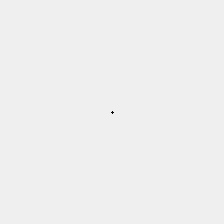

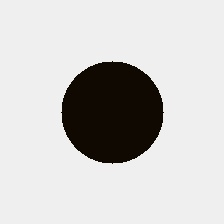

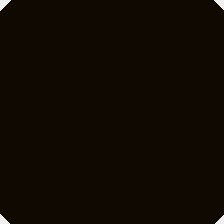

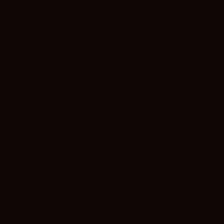

In [5]:
radii = [1, 51, 151, 166]
for r in radii:
    train_ds, _, _ = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered,
                                                  dot_radius=r,
                                                  grid_shape=GRID_SHAPE)
    imshow(train_ds[2]['image'])

## 4. Customize the model
We want to have a model with the fully connected layer removed, and for that, it seems easiest to subclass and override.

In [6]:
class PoolHeadResNet(tv.models.ResNet):
    def __init__(self, train_all_params=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_classes = nc.data.NUM_CLASSES
        # First, disable all other parameters.
        if not train_all_params:
            for param in self.parameters():
                param.requires_grad = False
        # A 1x1 convolution, representing effectively a fully connected, sub-batched at 7x7.
        self.fc2 = torch.nn.Conv2d(in_channels=NUM_FC_CHANNELS, out_channels=num_classes, kernel_size=1,stride=1)
        
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Stop above.
        #x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)
        x = self.fc2(x)
        return x
    
train_all_params = True
edited_resnet_model = None
if model_name == 'resnet18':
    edited_resnet_model = PoolHeadResNet(train_all_params, tv.models.resnet.BasicBlock, [2, 2, 2, 2])
elif model_name == 'resnet50':
    edited_resnet_model = PoolHeadResNet(train_all_params, tv.models.resnet.Bottleneck, [3, 4, 6, 3])
else:
    raise Exception('Not supported')
state = torch.hub.load_state_dict_from_url(tv.models.resnet.model_urls[model_name])
edited_resnet_model.load_state_dict(state, strict=False);

### 5.3 Dot only
This loss is a MLE loss that only considers the output unit that is associated with the
dot position. All other outputs are ignored. 

An obvious issue with this loss is that there is no incentive for the model to correctly
classify the background color. This is a loss that should give the model great leniency 
towards maximizing accuracy of the dot color classification at the expense of the background
color classification.

## 6. Training
Training loop.

In [7]:
# Copied from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization
normalize_transform =  tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
to_CHW_tensor_transform = tv.transforms.ToTensor()
data_transform = tv.transforms.Compose([to_CHW_tensor_transform, normalize_transform])
def train_test_val(radius):
    # tv.transforms.ToTensor will swap the dimensions from HWC to CHW
    train_ds, test_ds, val_ds = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered,
                                                            dot_radius=radius,
                                                            grid_shape=GRID_SHAPE)
    DataSplit = namedtuple('DataSplit', ['ds', 'loader', 'size'])
    splits = {
        'train': DataSplit(train_ds, torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=4, drop_last=True), len(train_ds)),
        'test':  DataSplit(test_ds,  torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4, drop_last=True), len(test_ds)),
        'val':   DataSplit(val_ds,   torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, drop_last=True), len(val_ds))
    }
    splits['val'].ds.transform = data_transform
    splits['train'].ds.transform = data_transform
    splits['test'].ds.transform = to_CHW_tensor_transform
    return splits

def train_model(model, datasplits, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #for inputs, labels in dataloaders[phase]:
            for batch in datasplits[phase].loader:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    outputs = outputs[:, :, CENTER_ACTIVATION, CENTER_ACTIVATION]
                    loss = torch.nn.functional.cross_entropy(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(labels == outputs)
            if phase == 'train':
                scheduler.step()

            denom = datasplits[phase].size
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects.double() / denom

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

## 7. Investigate model
To explore the nature of the predictions, I want an array with dimensions (label, prediction) and values are tallies. Accuracy for each label is then the diagonal divided by the sum along the prediction dimension. Overall accuracy is the sum along the diagonal divided by the complete sum. 

In [8]:
def test_model(model, dataloaders):
    model.eval()
    accuracy = None
    accuracy_details = torch.zeros((nc.data.NUM_CLASSES, nc.data.NUM_CLASSES)).to(device)
    ones = torch.ones(BATCH_SIZE, dtype=torch.float).to(device)
    for batch in dataloaders['test'].loader:
        inputs = normalize_transform(images).to(device)
        labels = batch['label'].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # Dot accuracy breakdown.
        center_pred = preds[:, CENTER_ACTIVATION, CENTER_ACTIVATION]
        # Linear index of the confusion matrix.
        linear_indexes = labels * nc.data.NUM_CLASSES + center_pred
        accuracy_details.put_(linear_indexes, ones, accumulate=True)
        
    tally = torch.sum(accuracy_details, dim=1)
    tally = tally.unsqueeze(1)
    accuracy_details_norm = accuracy_details / tally
        
    def print_acc_array(arr: np.ndarray, title=''):
        labels = nc.data.COLOR_ID_TO_LABEL.keys()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title(title)
        cax = ax.imshow(arr, cmap='viridis', vmin=0.0, vmax=1.0)
        fig.colorbar(cax)
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.set_ylabel('actual color')
        ax.set_xlabel('predicted color')
        plt.show()
    print_acc_array(accuracy_details_norm.cpu().numpy(), "Test set confustion matrix")
    print("Test set confusion matrix data:")
    print(accuracy_details_norm)
    print("Test set unnormalized confusion matrix data:")
    print(accuracy_details)
   

In [9]:
# Testing out numpy indexing.
a = np.array([
    [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]],
    [[-0, -1, -2], [-3, -4, -5], [-6, -7, -8], [-9, -10, -11]]])
a[:,[0,2], :]

array([[[ 0,  1,  2],
        [ 6,  7,  8]],

       [[ 0, -1, -2],
        [-6, -7, -8]]])

In [10]:
def test_all_models(models):
    label_count = nc.data.color_counts(train_test_val(radius=1)['test'].ds._labelled_colors)
    
    radius_label_ans = torch.zeros((len(models), nc.data.NUM_CLASSES, nc.data.NUM_CLASSES))
    for idx,(radius,model_fn) in enumerate(models.items()):
        model = model_fn()
        model.eval()
        test_ds_loader = train_test_val(radius)['test'].loader
        
        accuracy = None
        accuracy_details = torch.zeros((nc.data.NUM_CLASSES, nc.data.NUM_CLASSES)).to(device)
        ones = torch.ones(BATCH_SIZE, dtype=torch.float).to(device)
        for batch in test_ds_loader:
            images = batch['image']
            inputs = normalize_transform(images).to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Dot accuracy breakdown.
            center_pred = preds[:, CENTER_ACTIVATION, CENTER_ACTIVATION]
            # Linear index of the confusion matrix.
            linear_indexes = labels * nc.data.NUM_CLASSES + center_pred
            #ones = torch.ones(labels.shape, dtype=torch.float).to(device)
            accuracy_details.put_(linear_indexes, ones, accumulate=True)

        tally = torch.sum(accuracy_details, dim=1)
        tally = tally.unsqueeze(1)
        #accuracy_details_norm = accuracy_details / tally
        radius_label_ans[idx] = accuracy_details
        
    # Plot
    radius_label_ans = radius_label_ans.cpu().numpy()
    x = models.keys()
    ys_accuracy = (np.diagonal(radius_label_ans, axis1=1, axis2=2) / label_count)[:, [0, 1, 3]]
    #ys = radius_label_ans[:,[0, 1, 3]]
    #y = radius_label_ans[:,1]
    #y = radius_label_ans[:,3]
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(x, ys_accuracy)
    for i,j in enumerate(ax1.lines):
        j.set_color(nc.data.plot_colors()[[0, 1, 3]][i])
    ax2.plot(x, ys_accuracy.min(axis=1))
#test_all_models(models)

## 7.2 Debug specific samples
The following methods are used to check how a model behaves for a specific image. 

In [11]:
def debug_img(model, img):
        input_ = torch.unsqueeze(normalize_transform(img), 0).to(device)
        output = model(input_)
        ans = torch.argmax(output, 1)[0]
        ans = ans.cpu().detach().numpy()
        img = img.numpy().swapaxes(0, -1)
        # cv2 draw has some issues if numpy arrays are not continuous,
        # and to fix spurious issues, copying seems to work.
        im_print = img.copy()
        #im_print *= 255
        nc.data.draw_overlay(im_print, ans)
        return im_print

    
def showfilter(model):
    filter_len = 512 if model_name == 'resnet18' else 2048
    cut_size = 128
    cuts = int(filter_len / cut_size)
    for i in range(cuts):
        w = model.fc2.weight.cpu().detach().numpy()
        w = np.squeeze(w)
        plt.matshow(w[:,i*cut_size:(i+1)*cut_size])
        plt.title(f'Fully-connected layer filter. Block part {i}/{cuts}')
        
        
def debug_model(model, test_ds):
    showfilter(model)
    # 3: hard
    # 9: blank
    # 10: orange
    # 14: easy, but machine performs poorly.
    interesting_samples = [test_ds[i] for i in (3, 8, 9, 10, 12, 13, 14, 17)]
    #ic(val_ds[0]['image'].shape)
    images = []
    labels = []
    print('Interesting examples:')
    for s in interesting_samples:
        im = debug_img(model, s['image'])
        images.append(im)
        labels.append(s['label'])
    imlist(images, labels)
    
    print('Other examples:')
    print("(Tab by correct label. The grids are the model outputs)")
    num_samples = 50
    images, labels = zip(*map(lambda s: (debug_img(model, s['image']), s['label']), 
                              (test_ds[s] for s in range(num_samples))))
    imlist(images, labels, use_tabs=True)

### 8. Run Experiment. 
Train one of two models (resnet18 or resnet50) with 4 types of losses with gradient descent. Test the accuracy of each model-loss pair.

ic| radius_label_ans.shape: (119, 4, 4)


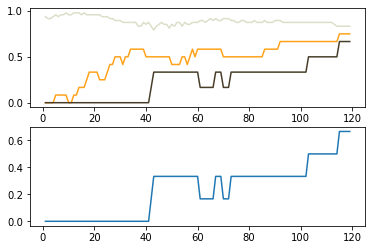

In [16]:
models = {}
def testall(pretrained=True):
    dot_radii = range(1, 120, 1)
    num_epochs = 15
    for radius in dot_radii:
        def model_fn():
            save_path = './resources/exp_1_7_1/{model_name}_{radius}_model_save'
            model = copy.deepcopy(edited_resnet_model).to(device)
            if pretrained:
                model.load_state_dict(torch.load(save_path.format(model_name=model_name, radius=radius)))
            else:
                datasets = train_test_val(radius)
                optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
                exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.9)
                model = train_model(model, datasets, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
                torch.save(model.state_dict(), save_path.format(model_name=model_name, radius=radius))
            return model
        models[radius] = model_fn
    test_all_models(models)
    
testall(pretrained=True)

Interesting examples:



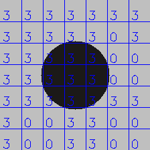
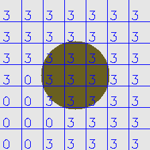
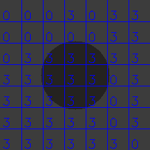
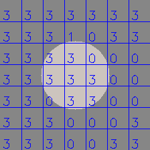
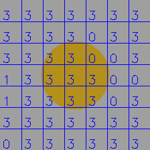
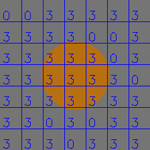
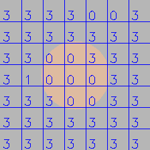
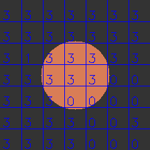


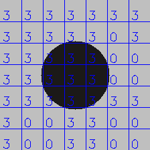
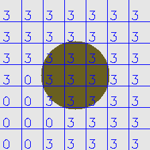
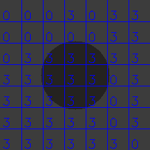
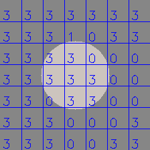
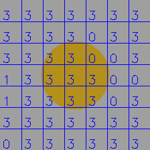
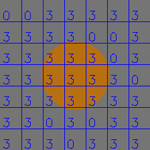
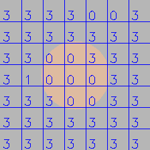
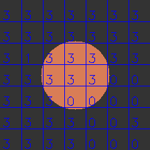

Other examples:
(Tab by correct label. The grids are the model outputs)



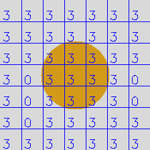
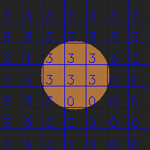
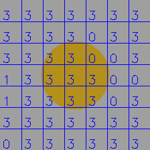
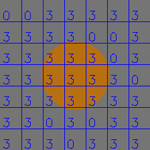
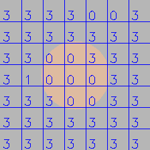
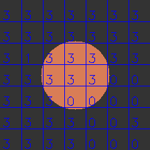
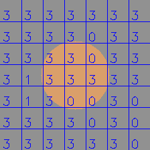
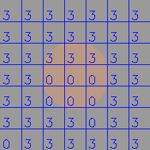
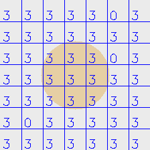
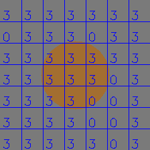
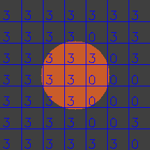
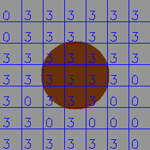
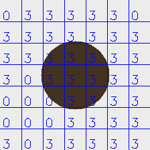
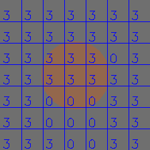
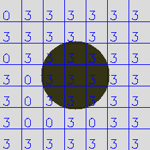
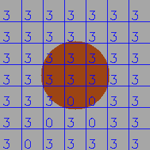
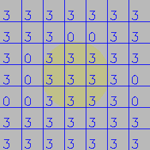
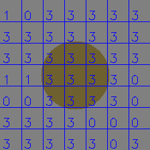
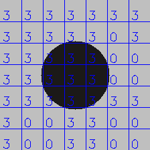
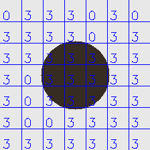
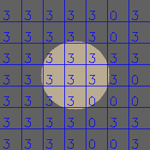
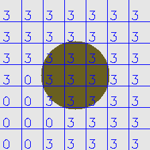
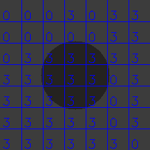
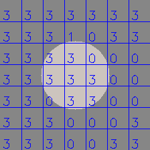
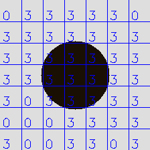
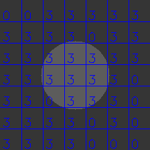
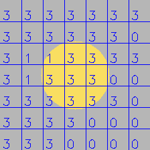
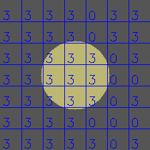
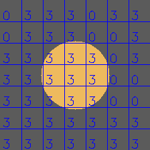
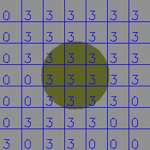
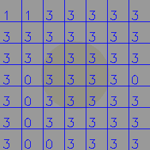
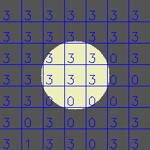
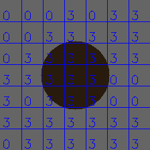
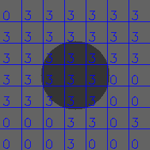
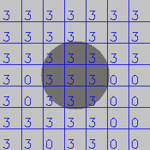
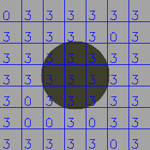
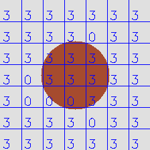
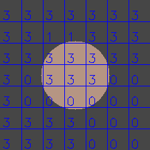
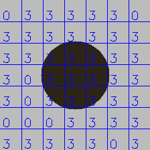
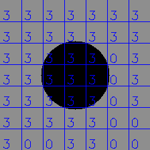
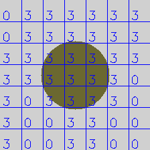
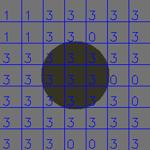
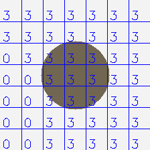
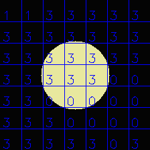
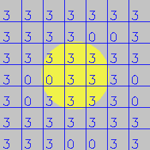
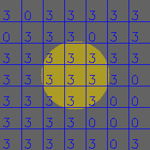
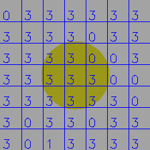
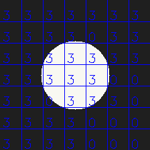
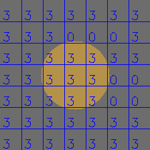
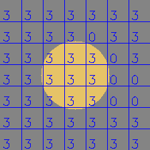


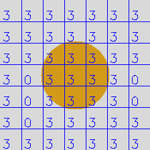
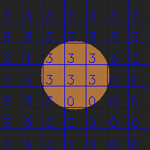
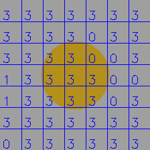
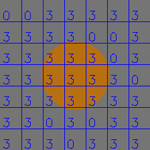
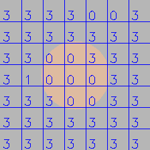
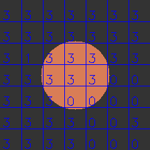
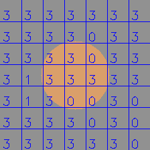
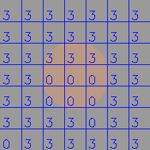
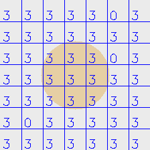
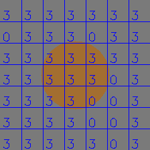
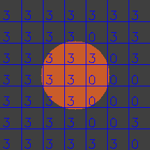
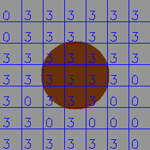
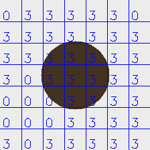
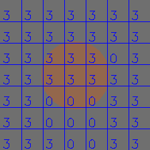
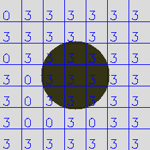
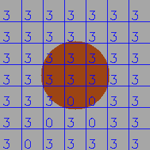
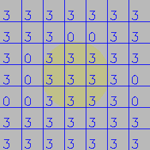
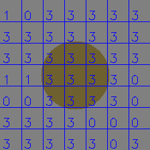
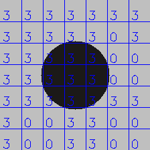
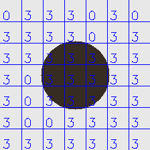
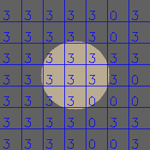
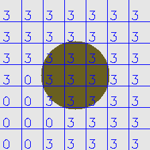
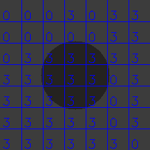
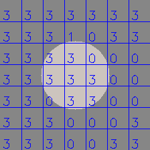
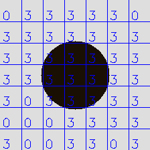
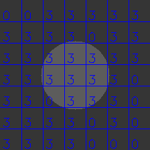
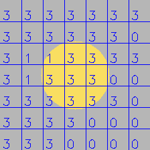
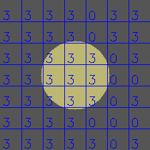
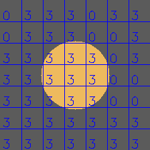
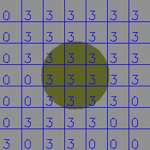
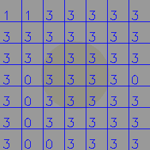
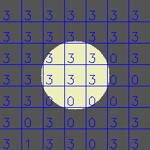
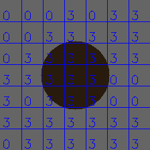
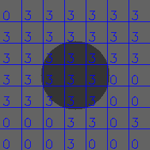
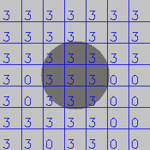
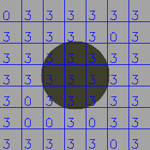
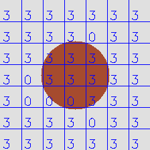
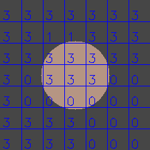
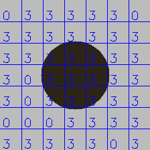
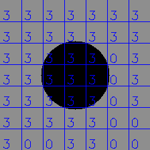
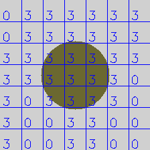
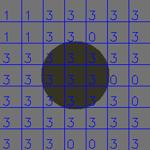
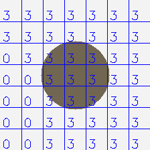
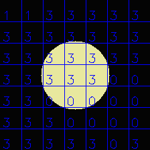
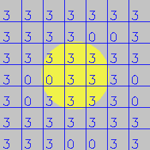
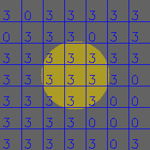
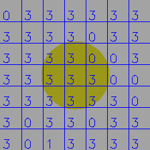
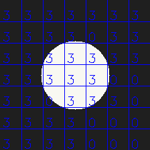
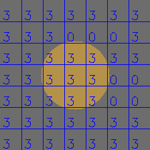
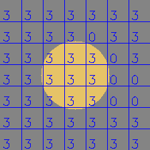

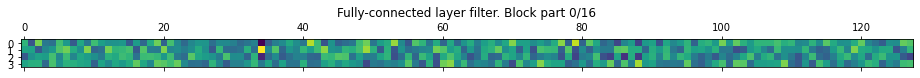

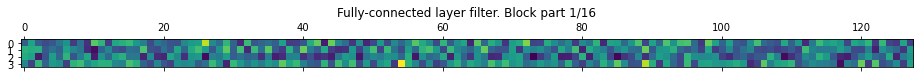

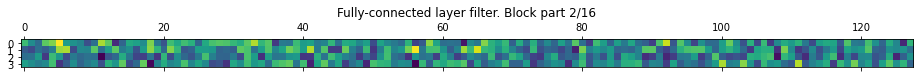

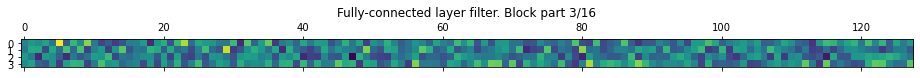

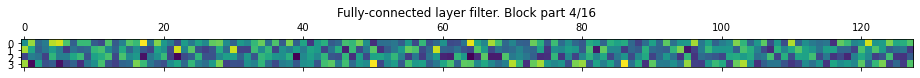

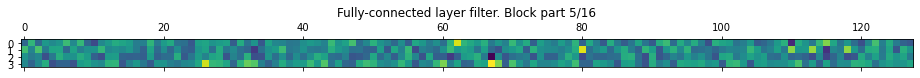

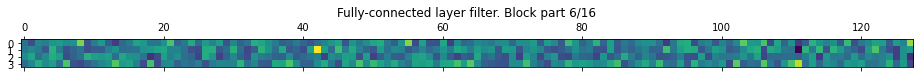

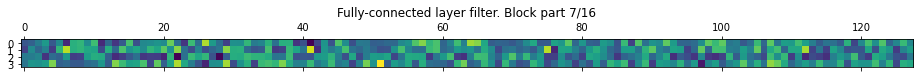

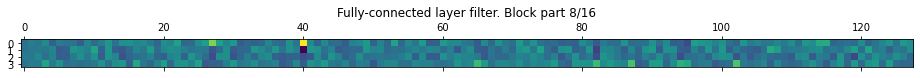

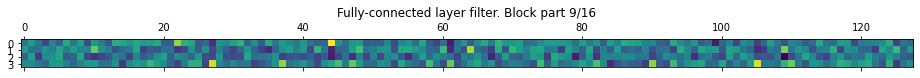

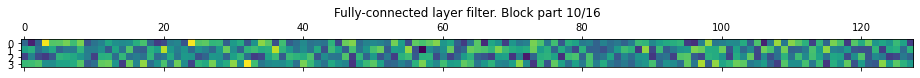

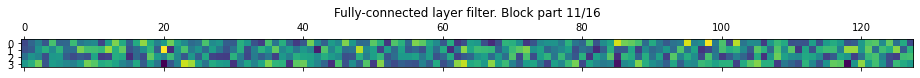

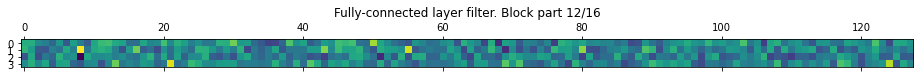

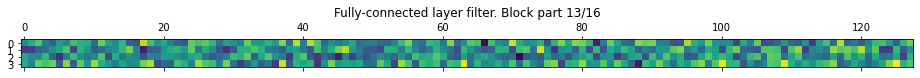

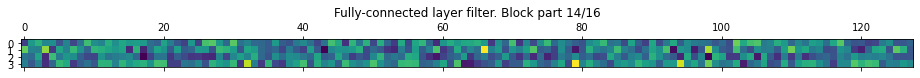

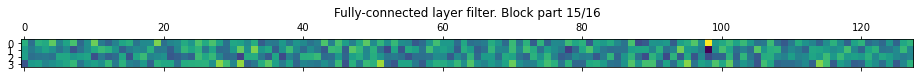

In [17]:
# Investigate one of the models in more detail.
radius = 51
debug_model(models[radius](), train_test_val(radius)['test'].ds)
#test_ds._labelled_colors.sort(key=lambda a:a[0])